# Bulldozers example

### Initialize & install modules

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install torch
!pip install nvidia-ml-py3 beautifulsoup4 fastprogress
!pip install bottleneck dataclasses

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from fastai.tabular import *

# Load data

In [3]:
# Download 'Blue book Bulldozer' dataset from Kallgle
data_path = 'data/bulldozer/TrainAndValid.csv'

In [4]:
# When loading, make sure we parse 'saledate' column
df_raw = pd.read_csv(data_path, low_memory=False, parse_dates=['saledate'])

In [5]:
df_ori = df_raw.copy()

### Define dependent variable

In [6]:
dep_var = 'SalePrice'

In [7]:
# Use log of salesprice instead of saleprice (as defined in the problem description)
df_ori.SalePrice = np.log(df_ori.SalePrice)

### Convert categorical entries

In [8]:
# Helper functions

sanitize_valid_chars = set('-_.abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')

def ifnone(val, val_default):
    "`a` if `a` is not None, otherwise `b`. Source: fast.ai"
    return val_default if val is None else val

def sanitize(s):
    ''' Sanitize a string by only allowing "valid" characters '''
    return ''.join(c for c in str(s) if c in sanitize_valid_chars)

In [9]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

class DfPreproc:
    ''' 
    Data Frame preprocessing. Calculate some field (i.e. dataframe column) transformations
    and store the results in 'columns_to_add' and 'columns_to_remove'. Then apply these
    changes to the original dataframe to create a new dataframe.    
    '''

    def __init__(self, df:DataFrame, columns_date=None, one_hot_max_cardinality:int=7):
        '''
        Parameters:
            df : dataFrame
            columns_date: Columns to be expanded into multiple date/time fields
            one_hot_max_cardinality: Max cardinality (i.e. number of categories) for 'one hot' encoding.
        '''
        self.df = df
        self.one_hot_max_cardinality = one_hot_max_cardinality
        self.columns_date = ifnone(columns_date, set())
        self.df_new = None
        self.categories = dict()
        self.columns_to_add = dict()
        self.columns_to_remove = set()

    def add_datepart(self, field_name:str, prefix:str=None, time:bool=True):
        '''
        Helper function that creates a new dataframe with all columns relevant to
        a date in the column `field_name`.
        Source: fast.ai 
        '''
        make_date(self.df, field_name)
        field = self.df[field_name]
        prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
        attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
                'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
        if time:
            attr = attr + ['Hour', 'Minute', 'Second']
        df = pd.DataFrame()
        for n in attr:
            df[prefix + n] = getattr(field.dt, n.lower())
        df[prefix + 'Elapsed'] = field.astype(np.int64) // 10 ** 9
        # Add to replace and remove operations
        self.columns_to_add[field_name] = df
        self.columns_to_remove.add(field_name)

    def category(self, field_name:str):
        " Convert field to category numbers "
        xi = self.df[field_name]
        xi_cat = xi.astype('category').cat.as_ordered()
        self.categories[field_name] = xi_cat
        df_cat = DataFrame()
        df_cat[field_name] = xi_cat.cat.codes
        # Add to replace and remove operations
        self.columns_to_add[field_name] = df_cat
        self.columns_to_remove.add(field_name)

    def create(self):
        """ Create a new dataFrame based on the previously calculated conversions """
        # Create new dataFrame
        df_new = self.df.copy()
        # Drop old columns categorical columns
        df_new.drop(list(self.columns_to_remove), axis=1, inplace=True)
        # Join new columns
        for c in self.columns_to_add:
            df_new = df_new.join(self.columns_to_add[c])
        self.df_new = df_new
        return df_new

    def make_date(self, df:DataFrame, date_field:str):
        " Make sure `df[field_name]` is of the right date type. Source: fast.ai "
        field_dtype = df[date_field].dtype
        if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
            field_dtype = np.datetime64
        if not np.issubdtype(field_dtype, np.datetime64):
            df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)

    def na(self, field_name:str):
        " Process 'na' columns (i.e missing data) "
        # Add '*_na' column
        xi = self.df[field_name].copy()
        df_na = DataFrame()
        df_na[f"{field_name}_na"] = xi.isna().astype('int8')
        # Replace missing values by median
        replace_value = xi.median()
        xi[xi.isna()] = replace_value
        df_na[field_name] = xi
        # Add operations
        self.columns_to_add[field_name] = df_na
        self.columns_to_remove.add(field_name)

    def new(self):
        " Preprocess and create a new dataframe from pre-processing transformations "
        self.preprocess()
        return self.create()

    def one_hot(self, field_name:str, has_na:bool):
        " Create a one hot encodig for 'field_name' "
        df_one_hot = pd.get_dummies(self.df[field_name], dummy_na=has_na)
        self.rename_category_cols(df_one_hot, f"{field_name}_")
        # Add to transformations
        self.columns_to_add[field_name] = df_one_hot
        self.columns_to_remove.add(field_name)

    def preprocess(self):
        '''
        Perform data frame pre-processing steps:
            - Convert categorical data
            - Convert on-hot encoding
            - Convert dates into multiple columns
        
        '''
        for c in self.df.columns:
            xi = self.df[c]
            has_na = (xi.isna().sum() > 0)

            if c in self.columns_date:
                self.add_datepart(c)
                if has_na:
                    print(f"{c}: date part + NA {xi.dtype}")
                    self.na(c)
                else:
                    print(f"{c}: date part")
            elif xi.dtype == 'O':
                values = xi.unique()
                count_cats = len(values)
                # Create transformations to convert field (column)
                if count_cats <= self.one_hot_max_cardinality:
                    print(f"{c}: one hot")
                    self.one_hot(c, has_na)
                elif pd.api.types.is_string_dtype(xi):
                    print(f"{c}: category")
                    self.category(c)
                else:
                    print(f"{c}: ok {xi.dtype}")                    
            else:
                if has_na:
                    print(f"{c}: NA {xi.dtype}")
                    self.na(c)
                else:
                    print(f"{c}: ok {xi.dtype}")

    def rename_category_cols(self, df, prepend):
        '''
        Rename dataFrame columns by prepending a string and sanitizing the name
        Used to rename columns of a 'one hot' encoding
        '''
        names = dict()
        for c in df.columns:
            name = f"{prepend}{sanitize(c)}"
            names[c] = name
        df.rename(columns=names, inplace=True)



In [10]:
dfpp = DfPreproc(df_ori, columns_date=['saledate'])
df = dfpp.new()

SalesID: ok int64
SalePrice: ok float64
MachineID: ok int64
ModelID: ok int64
datasource: ok int64
auctioneerID: NA float64
YearMade: ok int64
MachineHoursCurrentMeter: NA float64
UsageBand: one hot
saledate: date part
fiModelDesc: category
fiBaseModel: category
fiSecondaryDesc: category
fiModelSeries: category
fiModelDescriptor: category
ProductSize: one hot
fiProductClassDesc: category
state: category
ProductGroup: one hot
ProductGroupDesc: one hot
Drive_System: one hot
Enclosure: one hot
Forks: one hot
Pad_Type: one hot
Ride_Control: one hot
Stick: one hot
Transmission: category
Turbocharged: one hot
Blade_Extension: one hot
Blade_Width: one hot
Enclosure_Type: one hot
Engine_Horsepower: one hot
Hydraulics: category
Pushblock: one hot
Ripper: one hot
Scarifier: one hot
Tip_Control: one hot
Tire_Size: category
Coupler: one hot
Coupler_System: one hot
Grouser_Tracks: one hot
Hydraulics_Flow: one hot
Track_Type: one hot
Undercarriage_Pad_Width: category
Stick_Length: category
Thumb: on

### Split into training and validation

In [11]:
x, y = df.drop(dep_var, axis=1), df[dep_var]

In [12]:
x.head().transpose()

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
YearMade,2004,1996,2001,2001,2007
auctioneerID_na,0,0,0,0,0
auctioneerID,3,3,3,3,3
MachineHoursCurrentMeter_na,0,0,0,0,0
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand_High,0,0,1,1,0


In [13]:
# Sub-sample training set for speed
train_subset = 50_000
validate_subset = 12_000

tv = train_subset + validate_subset
x_train = x[-tv:-validate_subset]
y_train = y[-tv:-validate_subset]

# Validate
x_val = x[-validate_subset:]
y_val = y[-validate_subset:]

print(f"Trainig set: {len(x_train)}\tValidation set:{len(x_val)}")

Trainig set: 50000	Validation set:12000


# Train

In [14]:
# Functions to show training results

def rmse(x, y): return math.sqrt(((x - y)**2).mean())

def print_score(m):
    ret = [rmse(m.predict(x_train), y_train), rmse(m.predict(x_val), y_val), m.score(x_train, y_train), m.score(x_val, y_val)]
    print(ret)
    return ret

### Model with a single tree

In [15]:
# Train model: Zero (exploratory analysis)
m = RandomForestRegressor(n_jobs=-1, n_estimators=1, bootstrap=False)
m.fit(x_train, y_train)
print_score(m)

# Note: We should fit perfectly the test dataset

[1.293207299340885e-16, 0.38985942101382254, 1.0, 0.7213805984263469]


[1.293207299340885e-16, 0.38985942101382254, 1.0, 0.7213805984263469]

### Model with single (shallow) tree for interpretation

In [16]:
# Train model: Zero (exploratory analysis)
m = RandomForestRegressor(n_jobs=-1, n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_train, y_train)
print_score(m)

[0.49599920075647397, 0.5362467925029484, 0.5442877619403889, 0.47286154035841066]


[0.49599920075647397,
 0.5362467925029484,
 0.5442877619403889,
 0.47286154035841066]

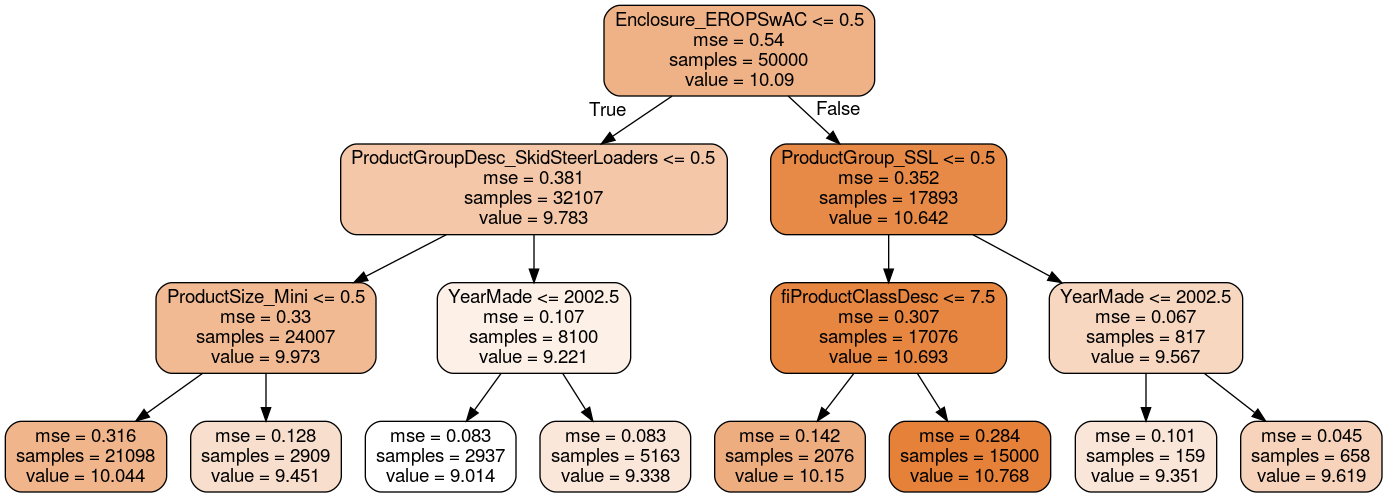

In [17]:
# Export the tree to a graphviz 'dot' format
from sklearn.tree import export_graphviz
from IPython import display

str_tree = export_graphviz(m.estimators_[0],
                           out_file='tree.dot',
                           feature_names=x_train.columns,
                           filled=True,
                           rounded=True)

# Convert 'dot' to 'png'
!dot -Tpng 'tree.dot' -o 'tree.png'

# Show image
from IPython.display import Image
Image(filename='tree.png') 

### Model with 10 trees

In [18]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 12.8 s, sys: 112 ms, total: 12.9 s
Wall time: 4.36 s
[0.0988149655470264, 0.28081719648750647, 0.9819126815317407, 0.8554418150233642]


[0.0988149655470264,
 0.28081719648750647,
 0.9819126815317407,
 0.8554418150233642]

### Model with  more trees and more randomness

In [19]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=3, max_features=0.5)
%time m.fit(x_train, y_train)
print_score(m)

CPU times: user 24 s, sys: 315 ms, total: 24.3 s
Wall time: 7.35 s
[0.12889770778952053, 0.25913054171589817, 0.969223507237119, 0.8769072444139347]


[0.12889770778952053,
 0.25913054171589817,
 0.969223507237119,
 0.8769072444139347]

# Prediction confidence

In [20]:
class ModelConfidence:
    ''' Calculate mean and variance of the estimation base on multiple modes '''
    
    def __init__(self, models, max_workers=None):
        '''
        Models can be either a is a list or an Ensembl estimator
        from SciKitLearn (e.g. a ranfdom forest)
        '''
        self.models = models.estimators_ if 'estimators_' in models else models
        self.max_workers = max_workers
        self.predictions = None
    
    def predict(self, x):
        ''' Predict using all models, return mean prediction '''
        self.predictions = np.stack([m.predict(x) for m in self.models])
        return self.predictions.mean(axis=0)

    def predict_single_sample(self, x, sample_number):
        ''' Predict using all models, return mean prediction for sample number '''
        xi = x_val.iloc[sample_number]
        xi = np.array(xi).reshape(1,-1)
        return self.predict(x)

    def std(self):
        " Standard deviation of previous predictions "
        return self.predictions.std(axis=0)
    
    def __repr__(self):
        return f"number of models: {len(self.models)}, mean : {np.mean(self.predictions)}, std: {np.std(self.predictions)}, predictions: {self.predictions}"


In [21]:
mc = ModelConfidence(m)

%time preds = mc.predict(x_val)

CPU times: user 2.33 s, sys: 413 µs, total: 2.33 s
Wall time: 2.33 s


(array([12., 11., 21., 29., ...,  4.,  9., 12.,  5.]),
 array([ 8.709255,  8.739926,  8.770597,  8.801268, ..., 11.684351, 11.715022, 11.745693, 11.776364]),
 <a list of 100 Patch objects>)

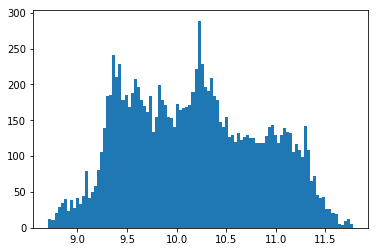

In [22]:
plt.hist(preds, bins=100)

(array([ 3.,  3., 12., 27., ...,  0.,  0.,  0.,  2.]),
 array([0.047297, 0.054471, 0.061644, 0.068818, ..., 0.743149, 0.750322, 0.757496, 0.76467 ]),
 <a list of 100 Patch objects>)

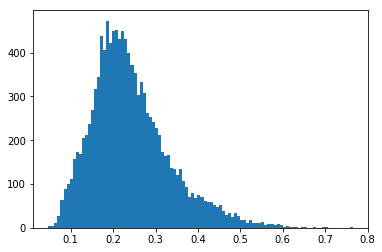

In [23]:
plt.hist(mc.std(), bins=100)

# Feature importance

In [24]:
from scipy.cluster import hierarchy as hc

class FeatureImportance:
    '''
    Estimate feature importance.
    How it works: Suffle a column and analyze how model performance is
    degraded. Most important features will make the model perform much
    worse when shuffled, unimportant features will not affect performance
    '''
    
    def __init__(self, model, x, y):
        self.model = model
        self.x = x
        self.y = y
        self.performance = dict()
        self.importance = None
        self.figsize = (16, 10)

    def analyze(self, verbose=False):
        # Base performance
        x_copy = self.x.copy()
        pred = self.model.predict(x_copy)
        # Shuffle each solumn
        for c in self.x:
            # Shuffle column 'c'
            x_copy = self.x.copy()
            xi = np.random.permutation(x_copy[c])
            x_copy[c] = xi
            # How did it perform
            pred_c = self.model.predict(x_copy)
            perf_c = self.rmse(pred, pred_c)
            self.performance[c] = perf_c
            if verbose:
                print(f"{c}: {perf_c}")
        # List of items sorted by importance (most important first)
        self.importance = sorted(self.performance.items(), key=lambda kv: kv[1], reverse=True)

    def dendogram(self):
        corr = np.round(scipy.stats.spearmanr(self.x).correlation, 4)
        corr_condensed = hc.distance.squareform(1-corr)
        z = hc.linkage(corr_condensed, method='average')
        fig = plt.figure(figsize=self.figsize)
        den = hc.dendrogram(z, labels=x_train.columns, orientation='left', leaf_font_size=16)
        plt.show()

    def most_important(self, importance_threshold=None, ratio_to_most_important=100, df=None):
        """
        Select features to keep either using an absolute value or
        a ratio to most important feature
        """
        if ratio_to_most_important is not None:
            most_important = fi.importance[0]
            importance_threshold = most_important[1] / ratio_to_most_important
            
        important_features = [f[0] for f in self.importance if f[1] > importance_threshold]
        unimportant_features = [f[0] for f in self.importance if f[0] not in important_features]
        return important_features, unimportant_features
        
    def plot(self, x=None):
        " Plot importance distributions "
        imp_x = np.array([f[0] for f in self.importance])
        imp_y = np.array([f[1] for f in self.importance])
        # Show bar plot
        plt.figure(figsize=self.figsize)
        plt.barh(imp_x, imp_y)
        # Show line plot
        plt.figure(figsize=self.figsize)
        plt.plot(imp_x, imp_y)
        # Dendogram
        self.dendogram(x)

    def rmse(self, x, y):
        return math.sqrt(((x - y)**2).mean())
    
    def __repr__(self):
        return "\n".join([f"{f[0]} : {f[1]}" for f in fi.importance])

SalesID: 0.03860663252766584
MachineID: 0.04647580568535087
ModelID: 0.10433801212320631
datasource: 0.011245809611790177
YearMade: 0.4409845251366195
auctioneerID_na: 1.2296273426016543e-15
auctioneerID: 0.01322192538919111
MachineHoursCurrentMeter_na: 0.004133583346267217
MachineHoursCurrentMeter: 0.02816962963552936
UsageBand_High: 0.003383309397689867
UsageBand_Low: 0.0075759678292436185
UsageBand_Medium: 0.005561819931538833
UsageBand_nan: 0.005699635323727466
saleYear: 1.1537206337510484e-15
saleMonth: 0.0065530258587416885
saleWeek: 0.01204546585510459
saleDay: 0.021556856958440805
saleDayofweek: 0.014646035856444417
saleDayofyear: 0.01420969037258583
saleIs_month_end: 0.0007405085231671777
saleIs_month_start: 0.0003046198846610408
saleIs_quarter_end: 0.0005271320317599724
saleIs_quarter_start: 1.2752914305877903e-15
saleIs_year_end: 1.1834234493208124e-15
saleIs_year_start: 1.1376545133882284e-15
saleHour: 1.079420009547458e-15
saleMinute: 1.1696784871443555e-15
saleSecond: 1.0

TypeError: dendogram() takes 1 positional argument but 2 were given

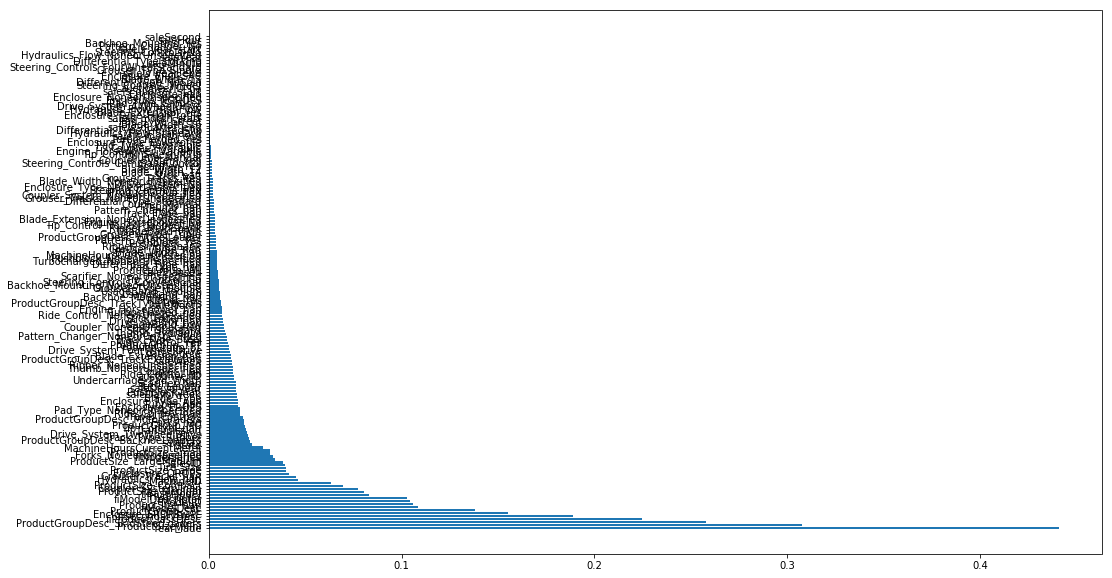

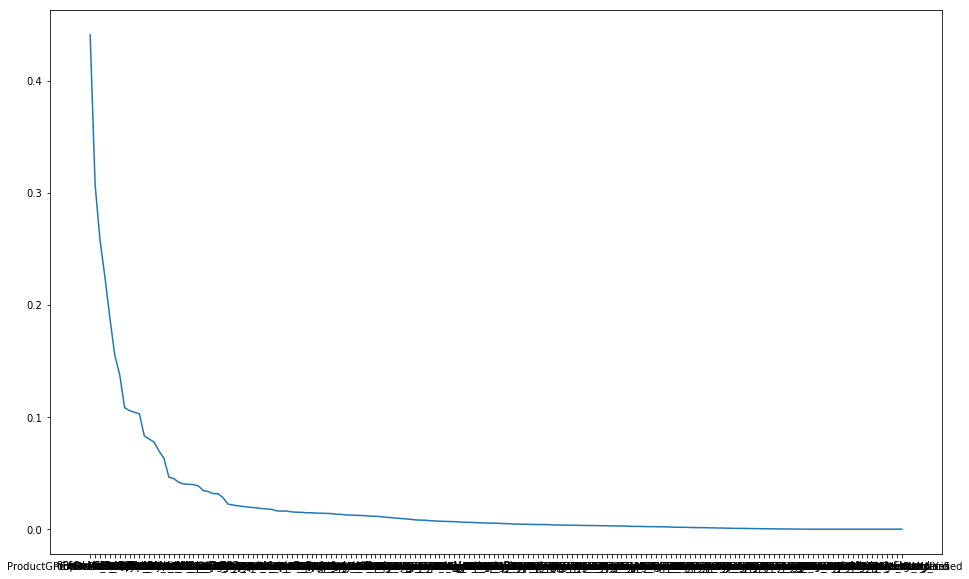

In [25]:
fi = FeatureImportance(m, x_val, y_val)
%time fi.analyze(verbose=True)
print(fi)
fi.plot(x_train)

### Select most important features

In [ ]:
# Select features to keep
imp, unimp = fi.most_important(ratio_to_most_important=50)

In [ ]:
len(imp) / len(fi.importance)

In [ ]:
x_train.drop(labels=unimp, axis=1, inplace=True)
x_val.drop(labels=unimp, axis=1, inplace=True)

In [ ]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=3)
%time m.fit(x_train, y_train)
print_score(m)

In [ ]:
fi = FeatureImportance(m, x_val, y_val)
%time fi.analyze()
print(fi)
fi.plot()

In [ ]:
fi

In [ ]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(x_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 10))
den = hc.dendrogram(z, labels=x_train.columns, orientation='left', leaf_font_size=16)
plt.show()